# Coursework 3: Part A - RNNs

#### Instructions

Please submit on CATe a zip file named *CW3_RNNs.zip* containing a version of this notebook containing your answers. Write your answers in the cells below each question.


#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Frkday 5th March, 2020**

## Recurrent models coursework

This coursework is separated into a coding and a theory component.

For the first part, you will use the Google Speech Commands v0.02 subset that you used in the tutorial part: http://www.doc.ic.ac.uk/~pam213/co460_files/ 

### Part 1 - Coding (70%)
In this part you will have to:

#### Part 1.1 (20%)

Implement the LSTM RNN cell.

#### Part 1.2 (30%)

- Modify the RNNModel class, such that it is a Bidirectional RNN.
- Compare vanilla RNN, GRU, LSTM, and bidirectional VS unidirectional RNNs and report their performance with respect to accuracy and time cost.

#### Part 1.3 (20%)

Then for your best model you will perform some improvements:
- In terms of architecture optimisation (number of layers, hidden state dimension)
- Better utilisation of the hidden state sequence output by the RNN, for classification.
- Report the improvements you achieved, as well as an explanation for why they worked.

### Part 2 - Theory (30%)

Here you will answer some theoretical questions about RNN training, and CTC -- no detailed proofs and no programming.

### Part 1: Coding

### Dataset

We will be using the Google [*Speech Commands*](https://www.tensorflow.org/tutorials/sequences/audio_recognition) v0.02 [1] dataset.

[1] Warden, P. (2018). [Speech commands: A dataset for limited-vocabulary speech recognition](https://arxiv.org/abs/1804.03209). *arXiv preprint arXiv:1804.03209.*

For the first part, you will use the Google Speech Commands v0.02 subset that you used in the tutorial part: http://www.doc.ic.ac.uk/~pam213/co460_files/ 

Set-up code and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!wget http://www.doc.ic.ac.uk/~pam213/co460_files/data_speech_commands_v0.02.zip
!mkdir data
! mkdir data/data_speech_commands_v0.02
!unzip data_speech_commands_v0.02.zip -d /content/data/data_speech_commands_v0.02/

In [3]:
import math
import os
from collections import defaultdict

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np
from scipy.io.wavfile import read
import librosa
from matplotlib import pyplot as plt
import torch.nn.functional as F

cuda = True if torch.cuda.is_available() else False
print(cuda)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

True


Data provider class definition.

Here you can give different configuration to the [mfcc function](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html). Additional keyword arguments are defined in the [melspectrogram function](https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html#librosa.feature.melspectrogram).

One may additionally consider standardising the samples (remove mean, divide by std) or performing data augmentation, e.g., by adding low variance white or noise.

In [0]:
class SpeechCommandsDataset(Dataset):
    """Google Speech Commands dataset."""

    def __init__(self, root_dir, split):
        """
        Args:
            root_dir (string): Directory with all the data files.
            split    (string): In ["train", "valid", "test"].
        """
        self.root_dir = root_dir
        self.split = split

        self.number_of_classes = len(self.get_classes())

        self.class_to_file = defaultdict(list)

        self.valid_filenames = self.get_valid_filenames()
        self.test_filenames = self.get_test_filenames()

        for c in self.get_classes():
            file_name_list = sorted(os.listdir(self.root_dir + "/data_speech_commands_v0.02/" + c))
            for filename in file_name_list:
                if split == "train":
                    if (filename not in self.valid_filenames[c]) and (filename not in self.test_filenames[c]):
                        self.class_to_file[c].append(filename)
                elif split == "valid":
                    if filename in self.valid_filenames[c]:
                        self.class_to_file[c].append(filename)
                elif split == "test":
                    if filename in self.test_filenames[c]:
                        self.class_to_file[c].append(filename)
                else:
                    raise ValueError("Invalid split name.")

        self.filepath_list = list()
        self.label_list = list()
        for cc, c in enumerate(self.get_classes()):
            f_extension = sorted(list(self.class_to_file[c]))
            l_extension = [cc for i in f_extension]
            f_extension = [self.root_dir + "/data_speech_commands_v0.02/" + c + "/" + filename for filename in f_extension]
            self.filepath_list.extend(f_extension)
            self.label_list.extend(l_extension)
        self.number_of_samples = len(self.filepath_list)

    def __len__(self):
        return self.number_of_samples

    def __getitem__(self, idx):
        sample = np.zeros((16000, ), dtype=np.float32)

        sample_file = self.filepath_list[idx]

        sample_from_file = read(sample_file)[1]
        sample[:sample_from_file.size] = sample_from_file
        sample = sample.reshape((16000, ))
        
        ########################################################################
        ## YOU MAY CONFIGURE HERE.
        ########################################################################
        sample = librosa.feature.mfcc(y=sample, sr=16000, hop_length=512, n_fft=2048).transpose().astype(np.float32)
        ########################################################################
        ## DO NOT CONFIGURE BEYOND HERE.
        ########################################################################
        
        label = self.label_list[idx]

        return sample, label

    def get_classes(self):
        return ['one', 'two', 'three']

    def get_valid_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "/data_speech_commands_v0.02/validation_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

    def get_test_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "/data_speech_commands_v0.02/testing_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

Load Dataset - you may vary batch size.

In [0]:
## MAKE SURE THIS POINTS INSIDE THE DATASET FOLDER.
# dataset_folder = "/content/drive/My Drive/" # this should change depending on where you have stored the data files
dataset_folder = "/content/data"

train_dataset = SpeechCommandsDataset(dataset_folder,
                                      "train")
valid_dataset = SpeechCommandsDataset(dataset_folder,
                                      "valid")

test_dataset = SpeechCommandsDataset(dataset_folder,
                                     "test")

## YOU MAY CHANGE THE BATCH SIZE.
batch_size = 100

num_epochs = 5
valid_every_n_steps = 5
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## Part 1.1 (20%)

Finalise the LSTM cell (you can base your code on that of the GRU cell).

You are allowed to use nn.Linear.

In [0]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):

        # hx is a tuple in the forward method of hx, cx

        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
            hx = (hx, hx)

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        hx, cx = hx

        # Reshape the input to vector form
        input = input.view(-1, input.size(1))

        gates = self.x2h(input) + self.h2h(hx)
        gates = gates.squeeze()

        # Split the large weight matrix containing (W_i, W_f. W_o, W_g)
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, dim = 1)

        # Softmax activations
        input_gate = torch.sigmoid(input_gate)
        forget_gate = torch.sigmoid(forget_gate)
        cell_gate = torch.tanh(cell_gate)
        output_gate = torch.sigmoid(output_gate)

        cy = torch.mul(cx, forget_gate) + torch.mul(input_gate, cell_gate)
        hy = torch.mul(output_gate, torch.tanh(cy))

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        return (hy, cy)

class BasicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        super(BasicRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        if self.nonlinearity not in ["tanh", "relu"]:
            raise ValueError("Invalid nonlinearity selected for RNN.")

        self.x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

            
    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        input = input.view(-1, input.size(1))
        gates = self.x2h(input) + self.h2h(hx)
        hy = gates.squeeze()

        if self.nonlinearity is "tanh":
            hy = torch.tanh(hy)
        else:
            hy = torch.relu(hy)

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
            
        return hy

    
    
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)  
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        # Reshape the input to vector form
        input = input.view(-1, input.size(1))

        gate_x, gate_h = self.x2h(input), self.h2h(hx)
        gate_x, gate_h = gate_x.squeeze(), gate_x.squeeze()

        # Split the two gates gates reset (r), update (z) and output (g)
        x_r, x_z, x_g =  gate_x.chunk(3, dim = 1)
        h_r, h_z, h_g =  gate_h.chunk(3, dim = 1)

        # Softmax activations
        reset_gate = torch.sigmoid(x_r + h_r)
        update_gate = torch.sigmoid(x_z + h_z)
        out_gate = torch.tanh(x_g + (torch.mul(reset_gate, h_g)))

        hy = torch.mul(update_gate, hx) + torch.mul((1 - update_gate), out_gate)

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        return hy

In [0]:
class RNNModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size, hidden_method = None):
        super(RNNModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size

        if hidden_method not in ['attention', 'average', None]:
            raise ValueError("NOT EXISTING")
        self.hidden_method = hidden_method
        
        self.rnn_cell_list = nn.ModuleList()
        
        device_idx = 0
        self.device = torch.device(
                "cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu"
            )

        if mode == 'LSTM':
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
            self.rnn_cell_list.append(LSTMCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################


        elif mode == 'GRU':
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
        else:
            raise ValueError("Invalid RNN mode selected.")

        self.att_fc = nn.Linear(self.hidden_size, 1)
        self.fc = nn.Linear(self.hidden_size, self.output_size)

        
    def forward(self, input, hx=None):
        if hx is None:
             h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size)).to(self.device)
        else:
             h0 = hx

        outs = []

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        if self.mode is 'LSTM':
            #h0 is now a tuple for LSTMS with hx, cx
            if not isinstance(h0, tuple):
                c0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size)).to(self.device)

            hidden_state = [h0[layer,:,:] for layer in range(self.num_layers)]
            cell_state = [c0[layer,:,:] for layer in range(self.num_layers)]
            for time_seq in range(input.size(1)):
                for layer in range(self.num_layers):
                    if layer is 0:
                        hidden_out, cell_out = self.rnn_cell_list[layer](input[:, time_seq, :], (hidden_state[layer], cell_state[layer]))
                    else:
                        hidden_out, cell_out = self.rnn_cell_list[layer](hidden_state[layer - 1], (hidden_state[layer], cell_state[layer]))
                    hidden_state[layer] = hidden_out
                    cell_state[layer] = cell_out
                outs.append(hidden_out)

        else:

            hidden_state = [h0[layer,:,:] for layer in range(self.num_layers)]

            for time_seq in range(input.size(1)):
                for layer in range(self.num_layers):
                    if layer is 0:
                        hidden_out = self.rnn_cell_list[layer](input[:, time_seq, :], hidden_state[layer])
                    else:
                        hidden_out = self.rnn_cell_list[layer](hidden_state[layer - 1], hidden_state[layer])
                    hidden_state[layer] = hidden_out
                outs.append(hidden_out)

        if self.hidden_method is "attention":
            attention_outs = [out*torch.sigmoid(self.att_fc(out)) for out in outs]
            out = torch.stack(attention_outs)
            out = torch.sum(out, dim = 0)
        elif self.hidden_method is "average":
            out = torch.stack(outs)
            out = torch.mean(out, dim = 0)
        elif self.hidden_method is None:
            out = outs[-1].squeeze() # Related to Part 1.3.
        else:
            raise ValueError("Please Specify attention method")

        out = self.fc(out)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        return out
    

class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size, hidden_method = None):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        if hidden_method not in ['attention', 'average', None]:
            raise ValueError("NOT EXISTING")
        self.hidden_method = hidden_method

        device_idx = 0
        self.device = torch.device(
                "cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu"
            )

        self.rnn_cell_list = nn.ModuleList()
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        if mode == 'LSTM':
            self.rnn_cell_list.append(LSTMCell(self.input_size,
                                                self.hidden_size,
                                                self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                self.hidden_size,
                                                self.bias))

        elif mode == 'GRU':
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                            self.hidden_size,
                                            self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                self.hidden_size,
                                                self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                self.hidden_size,
                                                self.bias,
                                                "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                    self.hidden_size,
                                                    self.bias,
                                                    "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                self.hidden_size,
                                                self.bias,
                                                "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                self.hidden_size,
                                                self.bias,
                                                "relu"))
        else:
            raise ValueError("Invalid RNN mode selected.")
        
        self.att_fc = nn.Linear(self.hidden_size, 1)
        self.fc = nn.Linear(self.hidden_size * 2, self.output_size)
        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        
    def forward(self, input, hx=None):
        h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size)).to(self.device)
        hT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size)).to(self.device)            
            
        outs = []
        outs_rev = []
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        if self.mode is 'LSTM':

            #h0, hT are now tuples for LSTMS with hx, cx...
            if not isinstance(h0, tuple):
                c0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size)).to(self.device)
                h0 = (h0, c0)
            if not isinstance(hT, type):
                cT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size)).to(self.device)
                hT = (hT, cT)

            hidden_forward = [h0[0][layer,:,:] for layer in range(self.num_layers)]
            hidden_back = [hT[0][layer,:,:] for layer in range(self.num_layers)]
            cell_forward = [h0[1][layer,:,:] for layer in range(self.num_layers)]
            cell_back = [hT[1][layer,:,:] for layer in range(self.num_layers)]

            for time_seq in range(input.size(1)):
                for layer in range(self.num_layers):

                    if layer is 0:
                        hidden_out_f, cell_out_f = self.rnn_cell_list[layer](input[:, time_seq, :], (hidden_forward[layer], cell_forward[layer]))
                        hidden_out_b, cell_out_b = self.rnn_cell_list[layer](input[:, - (time_seq + 1), :], (hidden_back[layer], cell_back[layer]))
                    else:
                        hidden_out_f, cell_out_f = self.rnn_cell_list[layer](hidden_forward[layer - 1], (hidden_forward[layer], cell_forward[layer]))
                        hidden_out_b, cell_out_b = self.rnn_cell_list[layer](hidden_back[layer - 1], (hidden_back[layer], cell_back[layer]))
                                                                             
                    hidden_forward[layer] = hidden_out_f
                    hidden_back[layer] = hidden_out_b
                    cell_forward[layer] = cell_out_f
                    cell_back[layer] = cell_out_b

                outs.append(hidden_out_f)
                outs_rev.append(hidden_out_b)

        else: 

            hidden_forward = [h0[layer,:,:] for layer in range(self.num_layers)]
            hidden_back = [hT[layer,:,:] for layer in range(self.num_layers)]

            for time_seq in range(input.size(1)):
                for layer in range(self.num_layers):

                    if layer is 0:
                        hidden_out_f = self.rnn_cell_list[layer](input[:, time_seq, :], hidden_forward[layer])
                        hidden_out_b = self.rnn_cell_list[layer](input[:, - (time_seq + 1), :], hidden_back[layer])

                    else:
                        hidden_out_f = self.rnn_cell_list[layer](hidden_forward[layer - 1], hidden_forward[layer])
                        hidden_out_b = self.rnn_cell_list[layer](hidden_back[layer - 1], hidden_back[layer])

                    hidden_forward[layer] = hidden_out_f
                    hidden_back[layer] = hidden_out_b

                outs.append(hidden_out_f)
                outs_rev.append(hidden_out_b)

        if self.hidden_method is "attention":
            # Fully connect pass an attention parameter in [0, 1] and use as weighted sum
            attention_out = [out*torch.sigmoid(self.att_fc(out)) for out in outs]
            out = torch.stack(attention_out)
            out = torch.sum(out, dim = 0)

            attention_rev = [rev*torch.sigmoid(self.att_fc(rev)) for rev in outs_rev]
            out_rev = torch.stack(attention_rev)
            out_rev = torch.sum(out_rev, dim = 0)

            out = torch.cat((out, out_rev), dim = 1)

        elif self.hidden_method is "average":
            out = torch.stack(outs)
            out = torch.mean(out, dim = 0)

            rev = torch.stack(outs_rev)
            rev = torch.mean(rev, dim = 0)

            out = torch.cat((out,rev), dim = 1)

        elif self.hidden_method is None:
            out = outs[-1].squeeze() # Related to Part 1.3.
            out_rev = outs_rev[-1].squeeze()
            out = torch.cat((out, out_rev), dim = 1)

        else:
            raise ValueError("Please Specify attention method")

        out = self.fc(out)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################       
        
        return out

## Part 1.2 (30%)

In the following, experiment with different RNN architectures (RNN cell types, number of layers, hidden state dimensionality, MFCC configuration, unidirectional VS bidirectional) and report the accuracy (pay also attention to the training and validation cost), as well as training time. 

* What are your justifications for these results?

* On the notebook, leave the execution of your best model.

In [0]:
import time
import pickle

In [187]:
# with open("/content/drive/My Drive/bi_rnn_res.pickle", 'wb') as handle:
#     pickle.dump(saved_dict_bi, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/single_rnn_res.pickle', 'rb') as handle:
     saved_dict_t = pickle.load(handle)

with open('/content/drive/My Drive/bi_rnn_res.pickle', 'rb') as handle:
     saved_dict_bi_t = pickle.load(handle)

print(saved_dict_bi_t.keys())
print(saved_dict_t.keys())

def plt_me(dictionaries, fig_type = None, dict2 = None):

    to_plot = ['losses', 'validation', 'test'] if fig_type is None else fig_type
    plt.subplot2grid
    y_time = []
    x_time = [] 

    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)
    fig_tuple_list = [ax1, ax3, ax5, ax2, ax4, ax6] 
    plt.tight_layout()
    counter = 0
    for id, dictionary in enumerate(dictionaries):
        for plt_graph in to_plot:
            for type_key in dictionary.keys():
                ax = fig_tuple_list[counter] 
                iterations = dictionary[type_key]['iterations'][0]
                if plt_graph is 'losses':
                    y = dictionary[type_key]['loss'] 
                    x = np.arange(iterations)
                    plt_int = 5
                    ax.set_ylabel('Training Loss')
                elif plt_graph is 'validation':
                    y = [dictionary[type_key]['v_acc_list'][bb][0].item() for bb in range(len(dictionary[type_key]['v_acc_list']))]
                    x = [dictionary[type_key]['v_acc_list'][bb][1] for bb in range(len(dictionary[type_key]['v_acc_list']))]
                    ax.set_ylabel('Validation Accuracy')
                    plt_int = 1
                elif plt_graph is 'test':
                    y = [dictionary[type_key]['t_acc_list'][bb][0].item() for bb in range(len(dictionary[type_key]['t_acc_list']))]
                    x = [dictionary[type_key]['t_acc_list'][bb][1] for bb in range(len(dictionary[type_key]['t_acc_list']))]
                    plt_int = 1
                    ax.set_ylabel('Test Accuracy')
                elif plt_graph is 'time':
                    y_time.append(dictionary[type_key]['time'][0])
                    x_time.append(max(dictionary[type_key]['t_acc_list']))
                else:
                    raise ValueError("Wrong Figure Specification")
                
                ax.plot(x[::plt_int],y[::plt_int],label=type_key)
                ax.legend() 
                ax.set_xlabel('Iterations')
                if counter is 0:
                    ax.set_title('Unidirectional')
                elif counter is 3:
                    ax.set_title('Bidirectional')
            counter += 1    
    plt.tight_layout()

def time_plot(saved_dict_t,saved_dict_bi_t):  
    fig, ax = plt.subplots()
    for type_key in saved_dict_t.keys():

        time_uni = -saved_dict_t[type_key]['time'][0]
        time_bi = -saved_dict_bi_t[type_key]['time'][0]

        max_acc_uni = max([saved_dict_t[type_key]['t_acc_list'][bb][0].item() for bb in range(len(saved_dict_t[type_key]['t_acc_list']))])
        max_acc_bi = max([saved_dict_bi_t[type_key]['t_acc_list'][bb][0].item() for bb in range(len(saved_dict_bi_t[type_key]['t_acc_list']))])

        ax.scatter(time_uni, max_acc_uni, label = type_key)
        #ax.annotate(type_key + 'uni', (time_uni, max_acc_uni))

        ax.scatter(time_bi, max_acc_bi, label = (type_key+'_bi'))
        #ax.annotate(type_key + 'bi', (time_bi, max_acc_bi))

    plt.rcParams['figure.figsize'] = [7, 5]
    plt.xlabel("Time (s)")
    plt.ylabel("Maximum Accuracy")
    plt.ylim([65,95])
    # plt.xlim([600,800])
    plt.rcParams.update({'font.size': 10})
    plt.legend()

dict_keys(['GRU', 'LSTM', 'RNN_RELU', 'RNN_TANH'])
dict_keys(['GRU', 'LSTM', 'RNN_RELU', 'RNN_TANH'])


In [175]:
################################################################################
# TRAIN FROM HRE
################################################################################

seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3
hyper_settings = [32, 3]
saved_dict_bi, saved_dict = {}, {}

# for rnn_type in ['GRU', 'RNN_TANH', 'RNN_RELU', 'LSTM']: # Use this for loop if you want to compare the 4 cell types

# Best model: bi-directional LSTM is run once more to save the outputs for submission.
for rnn_type in ['LSTM']:

    rnn_dict = {}
    print(rnn_type)


    ## YOU MAY CONFIGURE THESE.
    hidden_dim = hyper_settings[0]
    layer_num = hyper_settings[1]
    bias = True

    # SELECT THE MODEL HERE
    # model = RNNModel(rnn_type, input_dim, hidden_dim, layer_num, bias, output_dim)
    model = BidirRecurrentModel('LSTM', input_dim, hidden_dim, layer_num, bias, output_dim)

    if torch.cuda.is_available():
        model.cuda()
        
    criterion = nn.CrossEntropyLoss()

    ## YOU MAY CONFIGURE THESE.
    learning_rate = 0.003
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # scheduler = torch.optim.lr_scheduler()

    loss_list = []
    v_acc_list = []
    t_acc_list = []

    iter = 0
    max_v_accuracy = 0
    reported_t_accuracy = 0
    max_t_accuracy = 0

    start_time = time.time()

    for epoch in range(num_epochs):
        for i, (audio, labels) in enumerate(train_loader):

            if torch.cuda.is_available():
                audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                labels = Variable(labels.cuda())
            else:
                audio = Variable(audio.view(-1, seq_dim, input_dim))
                labels = Variable(labels)

            optimizer.zero_grad()

            outputs = model(audio)

            loss = criterion(outputs, labels)

            if torch.cuda.is_available():
                loss.cuda()

            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())
            iter += 1

            if iter % valid_every_n_steps == 0:
                correct = 0
                total = 0
                for audio, labels in valid_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                v_accuracy = 100 * correct / total
                v_acc_list.append((v_accuracy, iter))
                
                is_best = False
                if v_accuracy >= max_v_accuracy:
                    max_v_accuracy = v_accuracy
                    is_best = True

                if is_best:
                    for audio, labels in test_loader:
                        if torch.cuda.is_available():
                            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                        else:
                            audio = Variable(audio.view(-1, seq_dim, input_dim))

                        outputs = model(audio)

                        _, predicted = torch.max(outputs.data, 1)

                        total += labels.size(0)

                        if torch.cuda.is_available():
                            correct += (predicted.cpu() == labels.cpu()).sum()
                        else:
                            correct += (predicted == labels).sum()

                    t_accuracy = 100 * correct / total
                    t_acc_list.append((t_accuracy, iter))
                    reported_t_accuracy = t_accuracy

                if  iter % 20 == 0:
                    print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, loss.item(), v_accuracy, reported_t_accuracy))

    elapsed_time = start_time - time.time()

    rnn_dict['time']=[elapsed_time]
    rnn_dict['iterations']=[iter]
    rnn_dict['loss']=loss_list
    rnn_dict['v_acc_list']=v_acc_list
    rnn_dict['t_acc_list']=t_acc_list
    rnn_dict['hyper_settings'] = hyper_settings

    saved_dict_bi['{}'.format(rnn_type)] = rnn_dict

LSTM
Iteration: 20. Loss: 0.9792317748069763. V-Accuracy: 54  T-Accuracy: 55
Iteration: 40. Loss: 0.8295696377754211. V-Accuracy: 57  T-Accuracy: 63
Iteration: 60. Loss: 0.8093881011009216. V-Accuracy: 67  T-Accuracy: 67
Iteration: 80. Loss: 0.6670001745223999. V-Accuracy: 68  T-Accuracy: 72
Iteration: 100. Loss: 0.5378456711769104. V-Accuracy: 79  T-Accuracy: 78
Iteration: 120. Loss: 0.4404749274253845. V-Accuracy: 80  T-Accuracy: 80
Iteration: 140. Loss: 0.35221996903419495. V-Accuracy: 82  T-Accuracy: 83
Iteration: 160. Loss: 0.31062138080596924. V-Accuracy: 87  T-Accuracy: 86
Iteration: 180. Loss: 0.25263845920562744. V-Accuracy: 87  T-Accuracy: 88
Iteration: 200. Loss: 0.4520988166332245. V-Accuracy: 88  T-Accuracy: 90
Iteration: 220. Loss: 0.25766515731811523. V-Accuracy: 89  T-Accuracy: 90
Iteration: 240. Loss: 0.2936289310455322. V-Accuracy: 89  T-Accuracy: 90
Iteration: 260. Loss: 0.2547782063484192. V-Accuracy: 91  T-Accuracy: 91
Iteration: 280. Loss: 0.3334778845310211. V-Ac

#### Results for Part 1.2

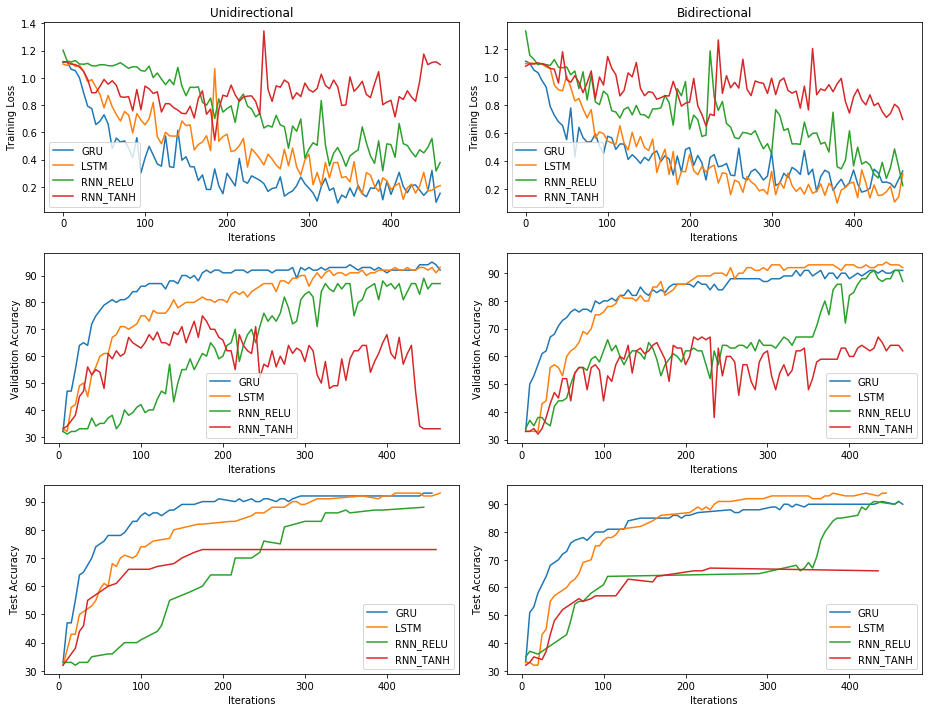

In [172]:
# RESULTS FOR UNI-DIRECTIONAL AND BI-DIRECTIONAL RNNS
plt.rcParams['figure.figsize'] = [13, 10]
plt_me(dictionaries=(saved_dict_t,saved_dict_bi_t))

During training we observe the losses for the GRU to decrease faster than those observed for the LSTM. This showcases the intuition that GRUs generally learn faster as they have fewer parameters. Indeed GRU and LSTM performances are very similar (accuracy graphs), as was expected. In the uni-directional case we observe similar results than in the bi-directional case. There are some slight improvements from the LSTM to the bi-LSTM, where test accuracy increases from 92 to 94%. Nevertheless the improvements are overall minor. Perhaps this might be because retrospectal information through the reversal rollous "outs_rev" might not be as important in speech classification of signals "one" "two" and "three" as the task is fairly simple. Moreover, we may also consider the fact that there might be little to gain from an already achieving uni-directional model. Perhaps in the case where ambiguities are more prone to happen (such as in classifien "40" or "14"), an increase in performance through the inclusion of bi-directional RNNs would be clearer. All in all we surpass the standards for accuracy and test accuracies of 84% (as suggested in Piazza) by achieving 94% accuracy for the bi-LSTMs and 93% for the GRU. 

It seems that the RNN_TANH model is severly limited in its learning capability with comparison to the RNN_RELU model. This was expected as the inclusion of the tanh activation function further amplifies vanishing gradient problem present in classical vanilla-RNNs, making learning even harder. On the other hand, the time sequence seems to be short enough for the RNN_RELU model to be sufficiently robust such that its training is sustained by the not so seemingly vanishing gradients. This is oserved especially in the bi-directional case, where the RNN_RELU model surprisingly achieves test accuracies up to an including 90%. Noteworthy is that in the case that the audio signals were to be increased further, then this RNN_RELU model would tend towards failure. If we study the graphs (losses and validation accuracies) for the 4 models, it is evident that the learning curves are more unstable for both RNN_RELU and RNN_TANH: vanishing and exploding gradients make it difficult for the learning process to stabilise, leading to noisy loss decrements during training. On the other hand, the gated models show a more traditional log-like convergence behaviour.

On a previous study I tested the effect of reducing the number of hidden layers (note that in this set-up, 3 hidden layers are used). This made training on lower-capacity models (RNN_TANH, RNN_RELU) very difficult, achieving accuracies of 45% and 51% respectively. This was not so much the case for LSTMs and GRUs as these have a larger number of parameters which allow a reduced number of hidden layers to generalise further within the training set.

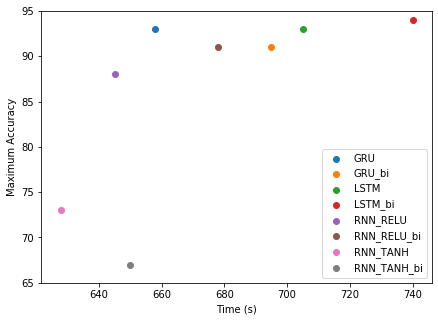

In [193]:
time_plot(saved_dict_t,saved_dict_bi_t)

As expected, GRU and LSTM models took longer to train than vanilla-RNN-based models. Moreover LSTMs show longer execution times than GRUs for a similar reason: the number of parameters in the cell types increases from RNN (1 Weight Tensor) to GRU (3 Weight Tensors) to LSTMs (4 Weight Tensors). Finally, a slight performance increase is seen from uni-directional to bi-directional methods, with a considerable increase in computational complexity. 

## Part 1.3 (20%)

RNN hidden state. In the code above in the RNNModel and BidirRecurrentModel, we utilise the final hidden state extracted by the model in order to make the final pass through a feed-forward layer towards a final prediction.

a) Can you think of reasons this might not be the best choice? Please write down two variations that could possibly yield better result.

b) Experiment with such alternative approaches in the code below in order to achieve a better result and report it below.

ANSWER TO PART 1.3 **(a)**

a) If we look back at an arbitrary sequence, there are a set of landmarks which can be used to segment an entire sequence into separate encodings. When we think of a song for example, there are particular events which are more important than others and hence carry more information. In contrast, if we consider every output in the time sequence, there are some tasks which will not benefit from this i.e. sentiment analysis requires every word to be processed because the last words might negate positive sentiment. Indeed there are also events in which information may be more important at the beginning of the audio: if we are classifying the words "bee" or "tea", evaluating the final rollout state of the RNN might not be the best idea as the first sound frames are indeed more resolvent. Nevertheless, there are also ocasions where the most important event may occur at an arbitrary position i.e. at the center of the recording. Here, even bi-directional RNNs might not be the best solution. For this reason it is important to capture interpretations at different points in time. 

In order to compromise with requirements in different applications as aforementioned, a mapping of "attention" can be learnt for any task by considering every hidden output state and summing them via a weighting average (note in this case, the weights are learnt too!). Notice that we map the hidden states to weights in [0, 1] via a sigmoid activation and use this weighting to sum over the entire set of rolled-out hidden outputs. The weighted-averaged hidden layer can then be used as the input to a feed-forward linear unit for classification. This approach is similar to an attention mechanism. In order to verify this, we will study naive mappings such as averaging pooling and compare those to the proposed weighted (attention) mapping.

ANSWER TO PART 1.3 **(b)**

b) We experiment with heuristics such as attention and average pooling, rather than solely evaluating the representation at the last hidden state. Indeed our best model for Part 1.2 consisted in a uni-directional GRU, trained at learning rates of 0.003 with 3 hidden layers of size 32. This achieved a test and validation accuracy of 94%. When we try:

(i) AVERAGE POOLING: See **1 cell** below for the output of training furing average pooling. Average pooling does not seem to improve the system. We find convergence rates to be relatively similar to those of the bidirectional LSTM in part 1.2. Most importantly, both validation and testing accuracies do not increase further than 93%. Nevertheless, from inspection of the training losses, we found that these are actually lower than those observed in the case of the bidirectional LSTM, whilst the bidirectional LSTM model achieves higher validation and test accuracies. This may suggest that using an average pooling has lower generalisation capabilities. However, it is important to stress that there are no clear indications of performance improvement via the implementation of average pooling.

(ii) ATTENTION: See **2 cells** below for the output of training including weighted attention mechanisms. We find that convergence is drastically improved. Indeed we achieve accuracies of 93 already in the 180th iteration. In contrast, this was only achieved over the last 100 iterations of the bi-directional LSTM model, which did not include attention (Part 1.2). An increase in covergence rate was expected due to the fact that attention mechanisms learn to focus on specific "landmarks" of the waveform which allow the RNN-based model to focus on learning those specific interpretations through time. Appart from convergence rates, the overall validation and testing accuracy reaches an impressive value of 95% from the 93% observed in the previous section. Although this increment seems small, it is indeed a 34% reduction in classification error. It would be interesting to see the effects of including attention mechanisms in the case where there the label space is increased (i.e. if we had to classify number between 1 and 10) in order to further verify their potential. 


In [170]:
# MODEL FOR AVERAGE POOLING
    # SCROLL DOWN TO VERIFY THE ACCURACIES
model = BidirRecurrentModel("LSTM", input_dim, hidden_dim, layer_dim, bias, output_dim, hidden_method = 'average')
# CODE BELOW IS THE SAME AS IN PART 1.2 AND IS THEREFORE NOT INCLUDED

Iteration: 5. Loss: 1.104169487953186. V-Accuracy: 32  T-Accuracy: 33
Iteration: 10. Loss: 1.0900053977966309. V-Accuracy: 42  T-Accuracy: 41
Iteration: 15. Loss: 1.0737087726593018. V-Accuracy: 41  T-Accuracy: 41
Iteration: 20. Loss: 1.0768581628799438. V-Accuracy: 44  T-Accuracy: 45
Iteration: 25. Loss: 0.9643733501434326. V-Accuracy: 50  T-Accuracy: 49
Iteration: 30. Loss: 0.8888295888900757. V-Accuracy: 52  T-Accuracy: 53
Iteration: 35. Loss: 0.8797830939292908. V-Accuracy: 57  T-Accuracy: 56
Iteration: 40. Loss: 0.7946158647537231. V-Accuracy: 62  T-Accuracy: 60
Iteration: 45. Loss: 0.7549945712089539. V-Accuracy: 57  T-Accuracy: 60
Iteration: 50. Loss: 0.8663741946220398. V-Accuracy: 66  T-Accuracy: 65
Iteration: 55. Loss: 0.7457496523857117. V-Accuracy: 67  T-Accuracy: 64
Iteration: 60. Loss: 0.712374210357666. V-Accuracy: 70  T-Accuracy: 69
Iteration: 65. Loss: 0.7734441161155701. V-Accuracy: 65  T-Accuracy: 69
Iteration: 70. Loss: 0.6921316385269165. V-Accuracy: 71  T-Accuracy

In [83]:
# MODEL FOR ATTENTION 
    # SCROLL DOWN TO VERIFY WE ACHIEVE MAXIMUM ACCURACIES OF 95
model = BidirRecurrentModel("LSTM", input_dim, hidden_dim, layer_dim, bias, output_dim, hidden_method = 'attention')
# CODE BELOW IS THE SAME AS IN PART 1.2 AND IS THEREFORE NOT INCLUDED

Iteration: 5. Loss: 1.1301331520080566. V-Accuracy: 32  T-Accuracy: 33
Iteration: 10. Loss: 1.057267427444458. V-Accuracy: 32  T-Accuracy: 33
Iteration: 15. Loss: 1.0684868097305298. V-Accuracy: 49  T-Accuracy: 49
Iteration: 20. Loss: 1.0186989307403564. V-Accuracy: 54  T-Accuracy: 54
Iteration: 25. Loss: 0.8689479827880859. V-Accuracy: 55  T-Accuracy: 56
Iteration: 30. Loss: 0.835503101348877. V-Accuracy: 60  T-Accuracy: 60
Iteration: 35. Loss: 0.7193415760993958. V-Accuracy: 70  T-Accuracy: 67
Iteration: 40. Loss: 0.6520054340362549. V-Accuracy: 74  T-Accuracy: 71
Iteration: 45. Loss: 0.733002245426178. V-Accuracy: 74  T-Accuracy: 73
Iteration: 50. Loss: 0.6142270565032959. V-Accuracy: 76  T-Accuracy: 74
Iteration: 55. Loss: 0.6111130118370056. V-Accuracy: 76  T-Accuracy: 75
Iteration: 60. Loss: 0.5800902247428894. V-Accuracy: 78  T-Accuracy: 77
Iteration: 65. Loss: 0.5843836665153503. V-Accuracy: 74  T-Accuracy: 77
Iteration: 70. Loss: 0.6628579497337341. V-Accuracy: 75  T-Accuracy:

## Part 2: Theoretical questions (30%)

Please answer the following theoretical questions in a cell below each respective question.

a. What is the _vanishing and exploding gradients problem_? When does it appear, and what is its practical significance? Please explain. (10%)

Vanilla recurrent neural networks share the same weights for the hidden state rollouts through time. If we decompose the weight matrix into its eigenvalues and corresponding eigenvectors this would mean that for large rollouts i.e. sequences in time the eigenvalues will either tend to 0 if these are smaller than 1 (and therefore gradients will vanish), or tend to infinity if the eigenvalues are larger than 1 (and at the same time overcome vanishing gradients from tanh). During back propagation through time, this means that the recurrent multiplicative gradient from the output loss to the inputs will either vanish or explode. This has the effect of severely hampering learning for long sequences: vanishing gradients force the RNN to stabilise at a sub-optimal point whilst exploding gradients show high irregularities in convergence (as the overall step size is massive). Notice that we realised during training that reducing the learning rates actually imroved convergence of RNN_RELU cell types (even up to validation and test accuracies of 90%). This could well be due to the fact that the exploding gradients are controlled by a smaller step size.

Note that either clipping the gradients or altering the learning rate does not solve the problem as one solution motivates the other problem further (clipping the gradients incites vanishing gradients and increasing the learning rates incites exploding gradients). The problem of vanishing gradients or even exploding gradients can be mitigated (but not completely erased) through inclusion of gating units such as the LSTM or the GRU. These have separate gates which allow the gradients to be controlled i.e. in LSTMS the forget gate allows passage of information to the next time step, controlling therfore the gradients rolled out in time. Moreover, the fact that the cell state gradient is additive allows gradient balancing as not all sub-gradients must agree. This is similar to why there is no vanishing/exploding gradient problems in standard FFNNs : balance of sub-gradients. 

Overall this problem affects deeper models: those which use information history of thousands of sequences prioir to taking a decision. Indeed these models are more useful in their practical application so it is therefore important to control the problem of vanishing/exploding gradients. 

b. The following (cartoon) plots show the gradients and the training curves for three models A, B, and C, trained on the same dataset. The three models are a RNN, a LSTM and a GRU, not necessarily in that order. (10%)

* Which could plausibly be which? Why? Please explain your reasoning.
* For which kinds of problems would you elect to use each of them?

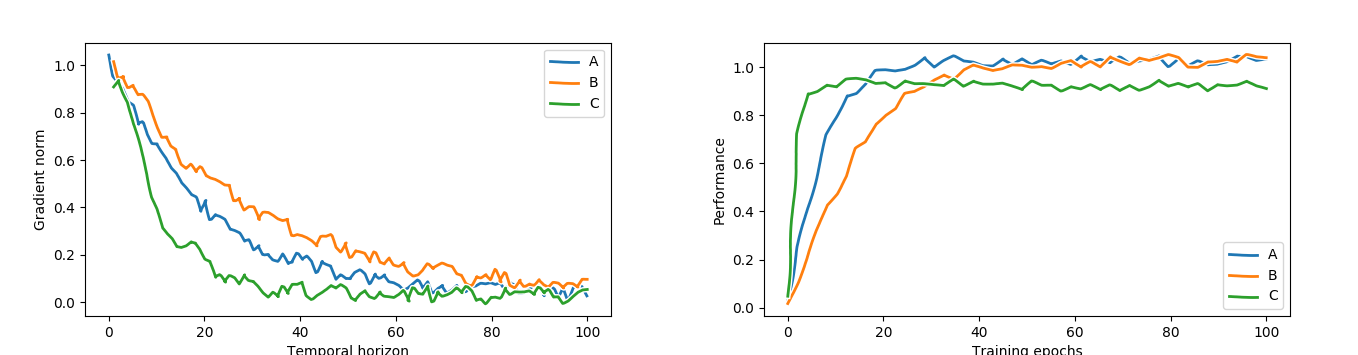

In [0]:
from IPython.display import Image, display
display(Image(filename='question_figs.png', width=850))

The solutions to each curve are most indactively: \\
A - GRU \\
B - LSTM \\
C - RNN \\

The reason for this is explained iteratively. First, RNNs show vanishing/exploding gradients. In this case as no model seems to have exploding gradients, then this would infer that the gradients are more likely to vanish. Observed on the leftmost graph, the gradients for model C seem to vanish more readily that those for models B and A, reaching almost 0 at the 40th epoch. Moreover, when we look at the rightmost graph, the performance of model C is inferior to that of models B and A. This would be expected in RNNs as they struggle to control their learning process. Additionally, the rate of increase in performance is much faster for model C. This is explainable for RNNs as these have much fewer parameters to learn from (4 sets of weight tensors in LSTMs and 3 sets in GRUs).

In contrast we observe models A and B achieving similar performances in the rightmost graph (GRU and LSTM performance debate). Indeed GRUs typically learn faster than LSTMs as they also have fewer parameters (3 instead of 4 sets of weight tensors). This already incites model A to be the GRU and model B to be the LSTM. Again, this behaviour is observed in the leftmost graph as the gradients for model A decay at a faster rate than those for model B.



c.  Write down five possible Connectionist Temporal Classification (CTC) paths (of no more than a length of eight) that correspond to the same label "LADDER". (10%)

5 options are (where dash "-" represents the empty set): \\
LAD-DER  \\
LADD-DER \\
LAAD-DER \\
LLAD-DER \\
LLAD-DDER \\